In [57]:
import datetime
import requests
from bs4 import BeautifulSoup
import calendar
import json
import time
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
base_url = "https://www.billboard.com/charts/hot-100/"

In [9]:
def get_last_day_of_month(year: int, month: int) -> str:
    # Get the last day of the given month and year.
    # calendar.monthrange returns (weekday, last_day_of_month)
    _, last_day = calendar.monthrange(year, month)
    return f"{year}-{month:02d}-{last_day:02d}"

In [11]:
get_last_day_of_month(2020, 1)

'2020-01-31'

In [13]:
def get_all_top_10_songs(year: int):
    all_songs = {}

    # Loop through each month from 1 (January) to 12 (December)
    for month in range(1, 13):
        # Get the last day of the current month
        last_day = get_last_day_of_month(year, month)

        # Construct the URL for the Billboard Hot 100 for the last day of the month.
        url = f"https://www.billboard.com/charts/hot-100/{last_day}/"

        # Send the request to the URL.
        headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
      }

        response = requests.get(url, headers=headers)
        time.sleep(1)
        if response.status_code != 200:
            print(f"Error fetching the page for {last_day}: {response.status_code}")
            continue

        # Parse the page content using BeautifulSoup.
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the song entries (assumes the same structure for each page)
        song_entries = soup.find_all('ul', class_='o-chart-results-list-row')

        if not song_entries:
            print(f"Failed to find songs for {last_day}. Please check the HTML structure.")
            continue

        # List to hold the top 10 songs for each month
        songs = []

        # Loop through the first 10 song entries and extract details.
        for entry in song_entries[:10]:
            # Extract rank
            rank_tag = entry.find('span', class_='c-label a-font-primary-bold-l u-font-size-32@tablet u-letter-spacing-0080@tablet')

            # Extract song title
            title_tag = entry.find('h3', id='title-of-a-story')

            # Extract artist(s)
            artist_tags = entry.find_all('span', class_='c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only')

            # First artist (has a specific class u-font-size-20@tablet)
            first_artist_tag = entry.find('span', class_='c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only u-font-size-20@tablet')

            # If the first artist is found, insert it at the start of the list
            if first_artist_tag:
                artist_tags.insert(0, first_artist_tag)  # Insert the first artist at the beginning

            # Skip entry if any required data is missing
            if not rank_tag or not title_tag or not artist_tags:
                continue

            # Extract rank, title, and artists
            rank = rank_tag.text.strip()
            song_title = title_tag.text.strip()

            first_artist = artist_tags[0].text.strip() if artist_tags else ''
            additional_artists = [artist.text.strip() for artist in artist_tags[1:]]
            all_artists = first_artist + (' ft. ' + ', '.join(additional_artists) if additional_artists else '')

            # Add the song to the list for this month
            songs.append(f"{song_title} by {all_artists}")

        # Store the top 10 songs for this month
        all_songs[last_day] = songs

    return all_songs

In [15]:
def get_top_songs_for_multiple_years(start_year: int, end_year: int):
    all_years_songs = {}

    # Loop through each year from start_year to end_year
    for year in range(start_year, end_year + 1):
        print(f"Fetching top 10 songs for {year}...")
        year_songs = get_all_top_10_songs(year)

        if year_songs:
            all_years_songs[year] = year_songs
        else:
            print(f"Failed to retrieve songs for {year}.")

    return all_years_songs

In [19]:
# Example usage: Get top 10 songs for each month from 2010 to 2023
start_year = 2010
end_year = 2023

top_songs_by_year = get_top_songs_for_multiple_years(start_year, end_year)

Fetching top 10 songs for 2010...
Fetching top 10 songs for 2011...
Fetching top 10 songs for 2012...
Fetching top 10 songs for 2013...
Fetching top 10 songs for 2014...
Fetching top 10 songs for 2015...
Fetching top 10 songs for 2016...
Fetching top 10 songs for 2017...
Fetching top 10 songs for 2018...
Fetching top 10 songs for 2019...
Fetching top 10 songs for 2020...
Fetching top 10 songs for 2021...
Fetching top 10 songs for 2022...
Fetching top 10 songs for 2023...


In [21]:
# Extract all song lists
all_songs = []

for year, months in top_songs_by_year.items():  # Loop through each year
    for month, songs in months.items():  # Loop through each month
        all_songs.extend(songs)  # Add the songs to the list

In [23]:
len(all_songs)

1680

In [25]:
def divide_list_into_dict(huge_list, chunk_size):
    """
    Divide a large list into a dictionary with sub-lists as values.

    :param huge_list: The original large list.
    :param chunk_size: The size of each sub-list.
    :return: A dictionary where keys are indices and values are sub-lists.
    """
    # Use dictionary comprehension to divide the list into chunks
    return {
        i: huge_list[i * chunk_size: (i + 1) * chunk_size]
        for i in range((len(huge_list) + chunk_size - 1) // chunk_size)  # Calculate number of chunks
    }

In [27]:
result = divide_list_into_dict(all_songs, 10)

# Output the result
#for key, value in result.items():
#    print(f"Key {key}: {value}")

In [29]:
result

{0: ['TiK ToK by Ke$ha',
  'Today Was A Fairytale by Taylor Swift',
  'Bad Romance by Lady Gaga',
  'BedRock by Young Money Featuring Lloyd',
  'Baby by Justin Bieber Featuring Ludacris',
  'Replay by Iyaz',
  'Sexy Chick by David Guetta Featuring Akon',
  'Empire State Of Mind by Jay-Z + Alicia Keys',
  'Hard by Rihanna Featuring Jeezy',
  'Hey, Soul Sister by Train'],
 1: ['Imma Be by The Black Eyed Peas',
  'TiK ToK by Ke$ha',
  'BedRock by Young Money Featuring Lloyd',
  'Bad Romance by Lady Gaga',
  'Need You Now by Lady Antebellum',
  'We Are The World 25: For Haiti by Artists For Haiti',
  'Hey, Soul Sister by Train',
  'How Low by Ludacris',
  'In My Head by Jason Derulo',
  'Say Aah by Trey Songz Featuring Fabolous'],
 2: ['Rude Boy by Rihanna',
  "Nothin' On You by B.o.B Featuring Bruno Mars",
  'Telephone by Lady Gaga Featuring Beyonce',
  'Need You Now by Lady Antebellum',
  'Break Your Heart by Taio Cruz Featuring Ludacris',
  'Imma Be by The Black Eyed Peas',
  'Hey, Soul

In [31]:
def get_genre(song_name):
    #using a more condensed way to use iTunes Search API
    search_url = f"https://itunes.apple.com/search?term={song_name}&media=music&entity=song&limit=1"
    response = requests.get(search_url)

    if response.status_code == 200: # Handle cases where no results are found
        data = response.json()
        if data['resultCount'] > 0:
            genre = data['results'][0]['primaryGenreName'] # Get the first result's genre
            return genre
        else:
            return print("Genre not found")
    else:
        return print("Error fetching data")


In [33]:
song_genres = [] # Store song with correlating genre

for i in all_songs: # Loop through each song and get its genre
    time.sleep(0.5)
    genre = get_genre(i)
    song_genres.append(genre)

Genre not found
Genre not found
Genre not found
Genre not found
Error fetching data
Error fetching data
Genre not found
Error fetching data
Genre not found
Genre not found
Genre not found
Genre not found
Genre not found
Error fetching data
Error fetching data
Genre not found
Genre not found
Genre not found
Genre not found
Genre not found


In [35]:
song_genres #19 song's genres cant be found, but thats our of 1680 songs

['Pop',
 'Country',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Pop',
 'Dance',
 'Hip-Hop/Rap',
 'Pop',
 'Pop',
 'Pop',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Country',
 'Pop',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'R&B/Soul',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Country',
 'Pop',
 'Pop',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Pop',
 'Pop',
 'Country',
 'Pop',
 'Pop',
 'R&B/Soul',
 'Pop',
 'Pop',
 'R&B/Soul',
 'Hip-Hop/Rap',
 'Pop',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Pop',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Pop',
 'R&B/Soul',
 'Hip-Hop/Rap',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Pop',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Hip-Hop/Rap',
 'Soundtrack',
 'R&B/Soul',
 'Pop',
 'Pop',
 'Pop Latino',
 'Hip-Hop/Rap',
 'Pop',
 'Hip-Hop/Rap',
 'Soundtrack',
 'Pop',
 'Pop Latino',
 'R&B/Soul',
 'Hip-Hop/Rap',
 'Pop',
 'Pop',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Hip-Hop/Rap',
 'Pop',
 'Pop',
 'R&B/Soul',
 'Soundtrack',
 'Pop Latino',
 'Hip-Hop/Rap',
 'Hip-Hop/Rap',
 None,
 None,
 'P

In [81]:
#divide_list_into_dict(song_genres, 10)

In [37]:
def divide_list_into_chunks(large_list, chunk_size):
    """
    Divide a large list into sub-lists of a specified size.

    :param large_list: The original large list.
    :param chunk_size: The size of each sub-list.
    :return: A list of sub-lists.
    """
    return [large_list[i:i + chunk_size] for i in range(0, len(large_list), chunk_size)]

# Example usage
result = divide_list_into_chunks(song_genres, 10)

# Output the result
#for chunk in result:
#    print(chunk)
result

[['Pop',
  'Country',
  'Pop',
  'Hip-Hop/Rap',
  'Pop',
  'Pop',
  'Dance',
  'Hip-Hop/Rap',
  'Pop',
  'Pop'],
 ['Pop',
  'Pop',
  'Hip-Hop/Rap',
  'Pop',
  'Country',
  'Pop',
  'Pop',
  'Hip-Hop/Rap',
  'Pop',
  'R&B/Soul'],
 ['Pop',
  'Hip-Hop/Rap',
  'Pop',
  'Country',
  'Pop',
  'Pop',
  'Pop',
  'Hip-Hop/Rap',
  'Pop',
  'Pop'],
 ['Hip-Hop/Rap',
  'Pop',
  'Pop',
  'Pop',
  'Country',
  'Pop',
  'Pop',
  'R&B/Soul',
  'Pop',
  'Pop'],
 ['R&B/Soul',
  'Hip-Hop/Rap',
  'Pop',
  'Pop',
  'Hip-Hop/Rap',
  'Pop',
  'Pop',
  'Pop',
  'Hip-Hop/Rap',
  'Pop'],
 ['Pop',
  'R&B/Soul',
  'Hip-Hop/Rap',
  'Pop',
  'Hip-Hop/Rap',
  'Pop',
  'Pop',
  'Pop',
  'Hip-Hop/Rap',
  'Pop'],
 ['Hip-Hop/Rap',
  'Pop',
  'Hip-Hop/Rap',
  'Soundtrack',
  'R&B/Soul',
  'Pop',
  'Pop',
  'Pop Latino',
  'Hip-Hop/Rap',
  'Pop'],
 ['Hip-Hop/Rap',
  'Soundtrack',
  'Pop',
  'Pop Latino',
  'R&B/Soul',
  'Hip-Hop/Rap',
  'Pop',
  'Pop',
  'Pop',
  'Hip-Hop/Rap'],
 ['Pop',
  'Hip-Hop/Rap',
  'Pop',
  'Pop',


Each chunk is the genres of songs within a month, within a year.

I want to count the total number of each genre within this sublist to ressemble the genre of the month.


In [39]:
#count number of genres in each month list
genre_counts = [dict(Counter(sublist)) for sublist in result]

In [41]:
len(genre_counts)

168

In [43]:
months = []
for i in top_songs_by_year.keys(): #year keys
    for j in top_songs_by_year[i].keys(): #monthly keys
        months.append(j) #return every month from 2010 - 2023

In [45]:
len(months)

168

In [47]:
# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(genre_counts).fillna(0)

# Set an index if the sublists represent specific months
df.index = [f" {i}" for i in months]
#df.index = pd.to_datetime(df.index, format='%Y-%m-%d')  # Ensure datetime index
#df['Year'] = df.index.year
#df['Month'] = df.index.strftime('%b')  # Short month names

# Ensure all values are integers
df = df.astype(int)

# Get the list of genres dynamically
#genres = df.columns.difference(['Year', 'Month'])  # Exclude Year/Month

# Group data by year for plotting
#grouped = df.groupby('Year')

# Output the DataFrame
print(df)

             Pop  Country  Hip-Hop/Rap  Dance  R&B/Soul  Soundtrack  \
 2010-01-31    6        1            2      1         0           0   
 2010-02-28    6        1            2      0         1           0   
 2010-03-31    7        1            2      0         0           0   
 2010-04-30    7        1            1      0         1           0   
 2010-05-31    6        0            3      0         1           0   
...          ...      ...          ...    ...       ...         ...   
 2023-08-31    4        3            1      0         0           0   
 2023-09-30    3        3            2      0         1           0   
 2023-10-31    1        4            2      0         1           0   
 2023-11-30    4        1            1      0         1           0   
 2023-12-31    0        0            1      0         0           0   

             Pop Latino  None  Alternative  Pop/Rock  ...  Hip-Hop  \
 2010-01-31           0     0            0         0  ...        0   
 2010-0

In [49]:
df.index = pd.to_datetime(df.index, errors='coerce')  # Convert index to datetime

In [51]:
df['Year'] = df.index.year
df['Month'] = df.index.strftime('%b')  # Extract short month names

In [53]:
grouped = df.groupby('Year')

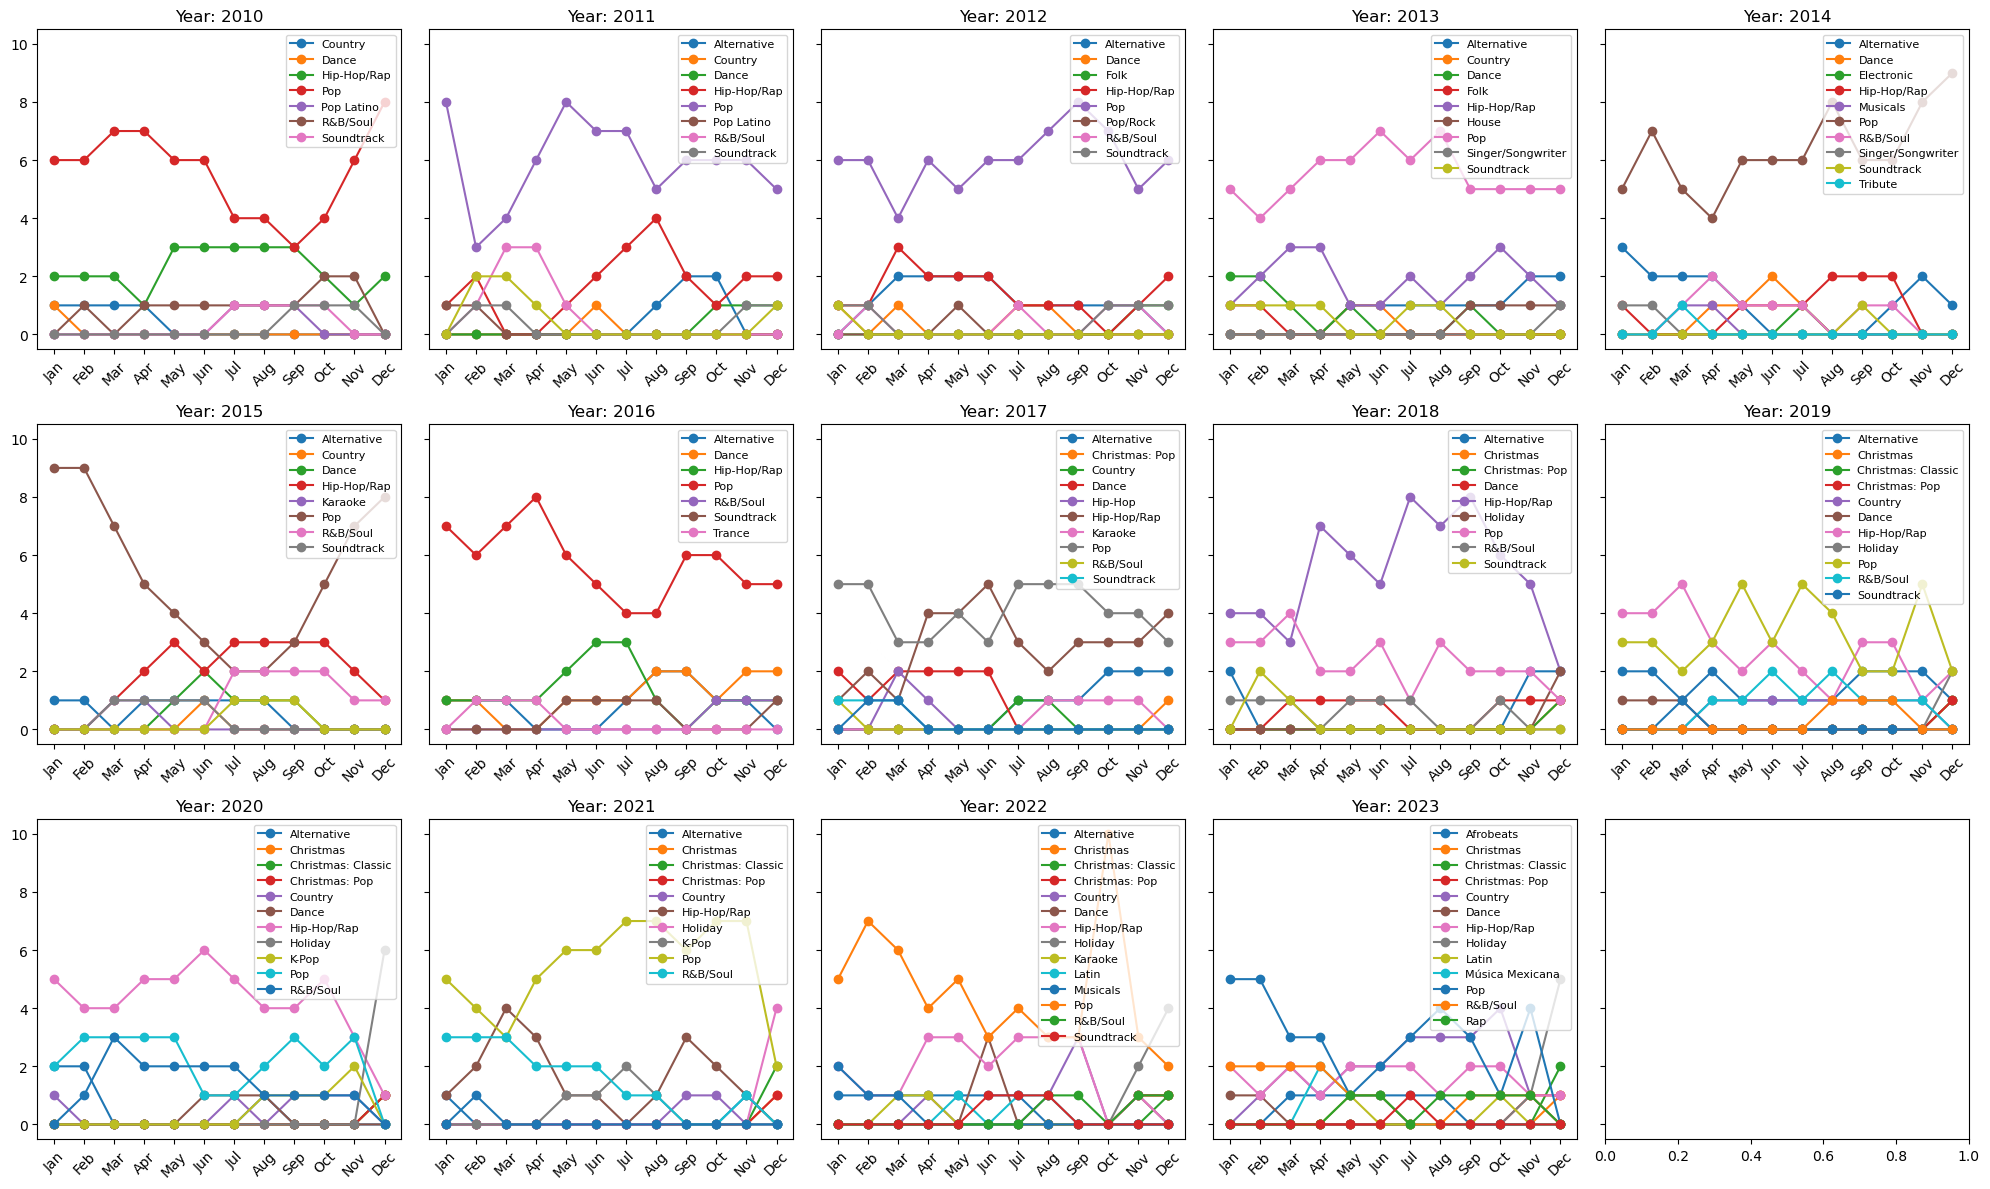

In [59]:
# List of genres (exclude Year and Month for plotting)
genres = df.columns.difference(['Year', 'Month'])

# Unique years in the dataset
years = df['Year'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12), sharey=True)
axes = axes.flatten()

# Iterate through each year and plot
for idx, year in enumerate(years):
    ax = axes[idx]
    year_data = grouped.get_group(year)  # Data for the specific year

    # Track active genres for the legend
    active_genres = []
    
    for genre in genres:
        #ax.plot(year_data['Month'], year_data[genre], label=genre, marker='o')
        if year_data[genre].sum() > 0:  # Check if the genre has any data
            ax.plot(year_data['Month'], year_data[genre], label=genre, marker='o')
            active_genres.append(genre)  # Add genre to the active list
    
    ax.set_title(f"Year: {year}")
    ax.set_xticks(range(12))
    ax.set_xticklabels(year_data['Month'], rotation=45)
    ax.legend(loc="upper right", fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()